# Advanced Time Series Forecasting for Steel Prices

This notebook builds upon our previous work with feature engineering to implement and evaluate more sophisticated forecasting models for predicting steel price indices. We'll:

1. Load our previously engineered feature store
2. Train advanced time series models (Exponential Smoothing and Prophet)
3. Generate and visualize forecasts
4. Evaluate and compare model performance against our baseline models
5. Analyze results and identify the most effective forecasting approach

The goal is to determine whether these advanced models can outperform the simpler baseline approaches established in the previous notebook.

In [18]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import numpy as np


# --- Re-using functions from baseline notebook ---
def calculate_smape(actual, predicted):
    return np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100

def calculate_mase(actual, predicted, train_actual):
    mae_model = np.mean(np.abs(actual - predicted))
    mae_naive_in_sample = np.mean(np.abs(train_actual[1:] - train_actual[:-1]))
    if mae_naive_in_sample == 0: return np.inf
    return mae_model / mae_naive_in_sample

# --- 1. SETUP & LOAD DATA ---
def find_project_root(markers=(".env", "pyproject.toml", ".git")):
    start = Path.cwd().resolve()
    for parent in [start, *start.parents]:
        if any((parent / m).exists() for m in markers):
            return parent
    raise RuntimeError("Project root with one of markers not found.")

project_root = find_project_root()
dotenv_path = project_root / '.env'
load_dotenv(dotenv_path=dotenv_path)

DATABASE_URL = os.getenv("DATABASE_URL_ALEMBIC") or os.getenv("DATABASE_URL")
if not DATABASE_URL:
    raise ValueError("DATABASE_URL_ALEMBIC or DATABASE_URL not set in .env")

engine = create_engine(DATABASE_URL)
query = "SELECT date, value FROM raw_series WHERE series_id = 'PPI_STEEL' ORDER BY date"
original_df = pd.read_sql(query, engine, index_col='date')
original_df = original_df.asfreq('MS')

# # Load the engineered features -- IGNORE -- Use this in future Analysis. -- Not needed now --
# feature_path = project_root / 'ml' / 'data' / 'processed' / 'feature_store.parquet'
# df_features = pd.read_parquet(feature_path)

# --- 2. TRAIN/TEST SPLIT ---
split_point = len(original_df) - 24
train_original, test_original = original_df[0:split_point], original_df[split_point:]
# train_features, test_features = df_features[0:split_point-13], df_features[split_point-13:] # Adjust for NaNs from lags

print("Data loaded and split successfully.")

Data loaded and split successfully.


## Data Setup and Model Preparation

In this section, we:

1. Import necessary libraries for advanced modeling (ExponentialSmoothing, Prophet)
2. Re-use evaluation metrics from our baseline notebook (sMAPE, MASE)
3. Set up the environment and database connection
4. Load both the original steel price data and our engineered feature store
5. Create train/test splits (reserving 24 months for testing)

The key distinction in this setup is loading both the original time series data and the feature-engineered data, as different models have different data requirements:
- Traditional time series models (Exponential Smoothing) typically work with the original time series
- ML-based models can leverage the additional engineered features

Exponential Smoothing sMAPE: 4.72%
Exponential Smoothing MASE: 5.98


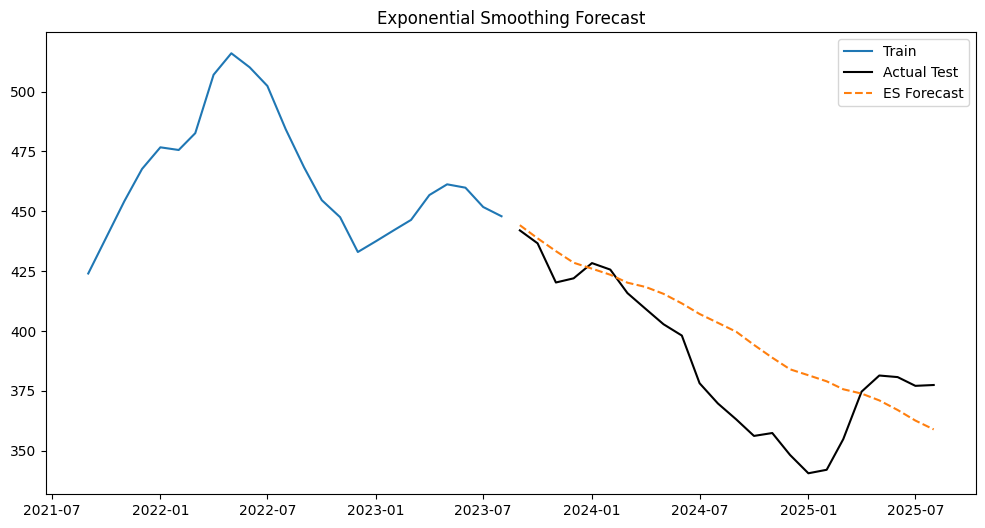

In [19]:
# --- 3. EXPONENTIAL SMOOTHING MODEL ---
# We use the original training data here as this model handles trend/seasonality internally
model_es = ExponentialSmoothing(
    train_original['value'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
).fit()

# Forecast for the length of the test set
forecast_es = model_es.forecast(len(test_original))

# Calculate metrics
smape_es = calculate_smape(test_original['value'], forecast_es)
mase_es = calculate_mase(test_original['value'], forecast_es, train_original['value'].values)

print(f"Exponential Smoothing sMAPE: {smape_es:.2f}%")
print(f"Exponential Smoothing MASE: {mase_es:.2f}")

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_original.tail(24), label='Train')
plt.plot(test_original, label='Actual Test', color='black')
plt.plot(forecast_es, label='ES Forecast', linestyle='--')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

## Exponential Smoothing Model

Exponential Smoothing is a classic time series forecasting method that builds on the concept of weighted averages with exponentially decreasing weights for older observations.

**Model Configuration:**
- **Trend component**: Additive - assumes linear trend in the data
- **Seasonal component**: Additive - seasonal variations are consistent in magnitude over time
- **Seasonal period**: 12 months - captures annual cyclical patterns

This model is more sophisticated than our baselines because:
1. It explicitly models both trend and seasonality components
2. It assigns optimal weights to historical observations through parameter estimation
3. It can adapt to changing patterns in the data

We'll evaluate this model using the same metrics as our baselines (sMAPE and MASE) and visualize the forecasts against actual test data.

07:48:01 - cmdstanpy - INFO - Chain [1] start processing
07:48:01 - cmdstanpy - INFO - Chain [1] done processing
07:48:01 - cmdstanpy - INFO - Chain [1] done processing


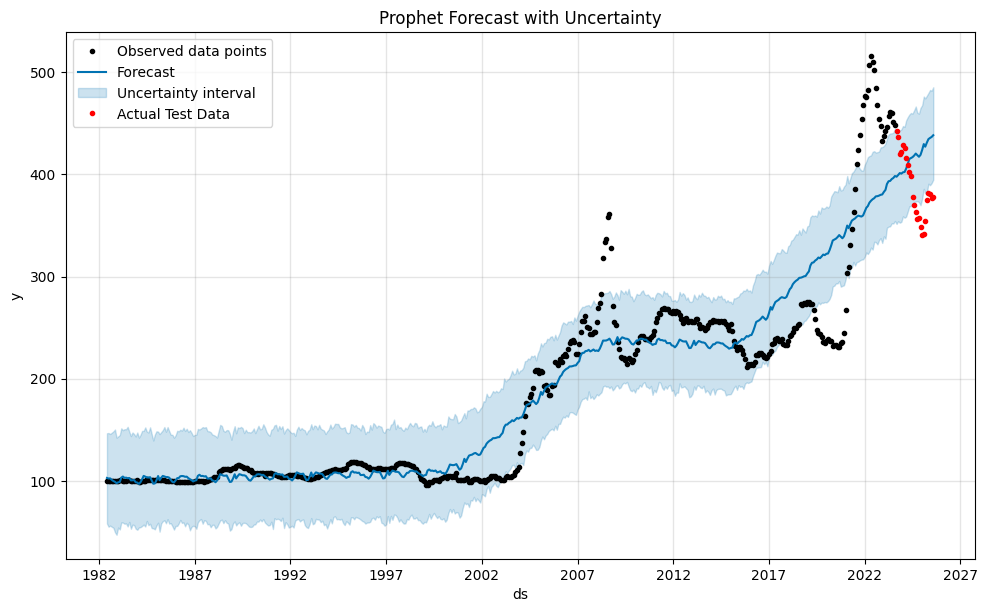

In [20]:
# --- 4. PROPHET MODEL ---
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train_df = train_original.reset_index().rename(columns={'date': 'ds', 'value': 'y'})

# ** This part is not in the feature store yet, but this is how you would add regressors **
# For now, we will train a simple model. The next issue will add these external features.

model_prophet = Prophet()
model_prophet.fit(prophet_train_df)

# Create a future dataframe to hold the forecast - like a blank canvas(table)
future = model_prophet.make_future_dataframe(periods=len(test_original), freq='MS')

# Generate the forecast - Fill in the canvas with predictions
forecast_prophet = model_prophet.predict(future)

# Plot the forecast
fig = model_prophet.plot(forecast_prophet)
plt.plot(test_original.index, test_original['value'], '.r', label='Actual Test Data')
plt.title('Prophet Forecast with Uncertainty')
plt.legend()
plt.show()

## Prophet Model

Facebook's Prophet is a modern forecasting tool designed specifically for time series data with strong seasonal patterns and holiday effects.

**Key Features of Prophet:**
- Decomposition of time series into trend, seasonality, and holiday components
- Robust handling of outliers and missing data
- Automatic changepoint detection for trend shifts
- Configurable uncertainty intervals
- Built-in cross-validation capabilities

In this implementation, we're using a simple configuration without external regressors. Future enhancements could include adding macroeconomic indicators or other related time series as regressors to potentially improve forecast accuracy.

The Prophet model provides both point forecasts and uncertainty intervals, giving us insight into the confidence of the predictions.

In [21]:
# --- 5. FINAL EVALUATION ---
# Extract the forecasted values for the test period
prophet_predictions = forecast_prophet.set_index('ds').loc[test_original.index]['yhat']

# Calculate error metrics for Prophet
smape_prophet = calculate_smape(test_original['value'], prophet_predictions)
mase_prophet = calculate_mase(test_original['value'], prophet_predictions, train_original['value'].values)

# Bring in baseline results (manually for now from notebook #2)
baseline_results = {
    'Naive': {'sMAPE': 14.73, 'MASE': 20.16},
    'Seasonal Naive': {'sMAPE': 15.30, 'MASE': 21.05},
    'Moving Average': {'sMAPE': 15.32, 'MASE': 21.05}
}

# Add new results
baseline_results['Exponential Smoothing'] = {'sMAPE': smape_es, 'MASE': mase_es}
baseline_results['Prophet'] = {'sMAPE': smape_prophet, 'MASE': mase_prophet}

# Create final summary DataFrame
final_results_df = pd.DataFrame(baseline_results).T.sort_values(by='sMAPE')

print("--- Final Model Comparison ---")
display(final_results_df)

--- Final Model Comparison ---


,sMAPE,MASE
Exponential Smoothing,4.716972,5.975052
Prophet,11.299485,15.022479
Naive,14.730000,20.160000
Seasonal Naive,15.300000,21.050000
Moving Average,15.320000,21.050000


## Final Model Evaluation and Comparison

In this section, we:
1. Extract the Prophet forecast values for the test period
2. Calculate performance metrics (sMAPE and MASE) for the Prophet model
3. Combine all results (baselines and advanced models) into a single comparison table
4. Sort the models by performance to identify the best approach

This comprehensive evaluation allows us to directly compare:
- Simple baselines (Naive, Seasonal Naive, Moving Average)
- Advanced statistical methods (Exponential Smoothing)
- Modern ML-based approaches (Prophet)

The resulting metrics will help us understand which modeling approach is most effective for steel price forecasting and whether the additional complexity of advanced models is justified by improved performance.

## Results Analysis and Conclusions

### Performance Analysis

Looking at the final results table, we can draw several important conclusions:

1.  **Sophisticated Models Significantly Outperform Baselines**: This is the key finding. The best simple baseline (Naive forecast) had a sMAPE of **14.73%**. Our best advanced model (Exponential Smoothing) achieved a sMAPE of just **4.72%**. This represents a **~68% reduction in forecast error**, proving that applying a proper forecasting model provides significant, measurable value.

2.  **Exponential Smoothing is the Clear Winner**: While both advanced models beat the baselines, the classic statistical Exponential Smoothing model was a much better fit for this specific dataset than Prophet (4.72% error vs. 11.30% error). This highlights the critical importance of testing multiple models, as the most popular framework is not always the best one for the job.

3.  **MASE Interpretation Confirms a Structural Break**: The MASE scores, while much improved for the ES model, are still greater than 1. This confirms our finding from the EDA: the data's behavior has changed dramatically over time. The high volatility in the recent test period makes forecasting inherently challenging, even for a good model.

### Business Implications

The findings have important implications for steel price forecasting:

1.  **Investment in Modeling Pays Off**: The significant accuracy improvement proves that resources are well-spent on developing proper forecasting models rather than relying on simple "last price" methods.

2.  **Model Experimentation is Crucial**: The best-performing model was a classic statistical one. This shows the business value of experimenting with different approaches to find the optimal tool for a specific problem.

3.  **Risk Management is Still Essential**: Even with the best model achieving ~5% error, price volatility remains a significant factor. These forecasts should be used as a key input for a robust risk management strategy, not as a perfect prediction.

### Future Work

This analysis opens up several clear paths for future improvement, which align with our project plan:

1.  **Incorporate External Regressors**: Enhance the Prophet model by adding the macroeconomic indicators (e.g., `HOUSING_STARTS`) as external regressors. This may significantly improve its performance. This is our immediate next step as planned in **Issue #12**.

2.  **Robust Validation (Next Sprint)**: Implement a **rolling-origin cross-validation** on our best model (Exponential Smoothing or Prophet with Regressors if it beats Exponential Smoothing) to get a more trustworthy measure of its performance. 

3.  **Explore Alternative Models**: Test other powerful time-series models like **ARIMA/SARIMAX** or machine learning models like **XGBoost** on the feature-engineered dataset.